In [169]:
import numpy as np
from numpy import std
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sy

from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from numpy import trapz

In [39]:
df = pd.read_csv("sql_df_preprocessed.csv")
df = df.drop(["full_url", "parsed_url", "event_time", "hostname"], axis=1)
df

,sql_keyword,params_length,request_volume,special_chars,values_to_length,injection
0,8,178,3.5,11,10.674157,1
1,0,5,3.5,1,20.000000,1
2,0,13,3.5,5,38.461538,1
3,0,21,3.5,3,14.285714,1
4,1,24,3.5,3,16.666667,1
...,...,...,...,...,...,...
6126,1,48,0.5,1,4.166667,0
6127,0,34,0.5,1,2.941176,0
6128,0,37,0.5,1,2.702703,0
6129,0,32,0.5,1,3.125000,0


In [40]:
# load data set and split it into metrics and classifier
np_dataset = df.to_numpy()
X = df.iloc[:, :-1].values
y = df. iloc [:, -1].values

print(X.shape)
print(y.shape)

(6131, 5)
(6131,)


# Find best folds split and number of neighbors

Register in pandas data frame accuracies for folds in range 2-10 and neighbors range 2-5

In [41]:
round = 1

ml_results_columns = ["folds", "neighbors", "accuracy"]
ml_results = pd.DataFrame(columns=ml_results_columns)

for folds in range(2,11):
    #print(f'Test for {folds} folds')
    # init cross validation
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)
    # split into folds
    for train, test in kfold.split(np_dataset):
        X_train = np_dataset[train][:, :-1]
        y_train = np_dataset[train][:, -1]

        X_test = np_dataset[test][:, :-1]
        y_test = np_dataset[test][:, -1]

        neighbors = range(2,6)
        for i in neighbors:
            # create model and train it
            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(X_train, y_train)

            # Test results
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            row = pd.DataFrame([[folds, i, accuracy]], columns=ml_results_columns)
            ml_results = pd.concat([ml_results, row], ignore_index=True)


        round = round + 1

Find the mean accuracy values in fold for given neighbors

In [42]:
tmp_columns = ["folds", "neighbors", "accuracy"]
tmp_df = pd.DataFrame(columns=ml_results_columns)

for folds in range(2,11):
    for i in range(2,6):
        tmp = ml_results.loc[(ml_results['neighbors'] == i) & (ml_results['folds'] == folds)]
        tmp = tmp.sum()['accuracy']/len(tmp)
        row = pd.DataFrame([[folds, i, tmp]], columns=tmp_columns)
        tmp_df = pd.concat([tmp_df, row], ignore_index=True)

In [43]:
tmp_df

,folds,neighbors,accuracy
0,2,2,0.998695
1,2,3,0.999021
2,2,4,0.998695
3,2,5,0.998532
4,3,2,0.998206
5,3,3,0.998369
6,3,4,0.998206
7,3,5,0.998369
8,4,2,0.998858
9,4,3,0.999348


Find for which number of neighbors in given fold accuracy is highest, and under what conditions accuracy is highest.

In [44]:
print('Accuracies comparison')
for folds in range(2,11):
    max_accuracy_index = tmp_df.loc[tmp_df['folds'] == folds]['accuracy'].idxmax()
    row = tmp_df.loc[max_accuracy_index]
    print(f'For {row.folds} folds ---  {row.neighbors} neighbors  ---- {row.accuracy} accuracy ')
    
max_value_row = tmp_df.loc[tmp_df['accuracy'].idxmax()]
print('Max accuracy')
print(f'For {max_value_row.folds} folds ---  {max_value_row.neighbors} neighbors  ---- {max_value_row.accuracy} accuracy ')

Accuracies comparison
For 2 folds ---  3 neighbors  ---- 0.9990214732119579 accuracy 
For 3 folds ---  3 neighbors  ---- 0.998369130874713 accuracy 
For 4 folds ---  3 neighbors  ---- 0.9993475778308033 accuracy 
For 5 folds ---  3 neighbors  ---- 0.99836867862969 accuracy 
For 6 folds ---  3 neighbors  ---- 0.998695208833671 accuracy 
For 7 folds ---  3 neighbors  ---- 0.9988582611126642 accuracy 
For 8 folds ---  3 neighbors  ---- 0.99918428586504 accuracy 
For 9 folds ---  3 neighbors  ---- 0.9988578887257302 accuracy 
For 10 folds ---  3 neighbors  ---- 0.9986949429037522 accuracy 
Max accuracy
For 4 folds ---  3 neighbors  ---- 0.9993475778308033 accuracy 


# Analisys of results for most optimal parameters

Folds: 4 and Neighbors: 3

Functions to evaluate results needed. 

Each functions has 2 arguments: test_vector and predicted_vector

Function return number of accuracy in given test (eg. value of FP or FN compered to whole data_set)


In [62]:
test_vector = []
predicted_vector = []

#init cross validation
kfold = KFold(n_splits=4, shuffle=True, random_state=1)
#split into folds
for train, test in kfold.split(np_dataset):
   X_train = np_dataset[train][:, :-1]
   y_train = np_dataset[train][:, -1]

   X_test = np_dataset[test][:, :-1]
   y_test = np_dataset[test][:, -1]

    # create model and train it
   knn = KNeighborsClassifier(n_neighbors=3)
   knn.fit(X_train, y_train)

   # Test results
   y_pred = knn.predict(X_test)
   print(y_pred)
   accuracy = accuracy_score(y_test, y_pred)
   print(accuracy)

   y_prob = knn.predict_proba(X_test)

   test_vector = [*test_vector, *y_test]
   predicted_vector = [*predicted_vector, *y_pred]

[1. 1. 1. ... 0. 0. 0.]
1.0
[0. 1. 1. ... 0. 0. 0.]
0.9986953685583823
[1. 1. 1. ... 0. 0. 0.]
0.9993476842791911
[1. 1. 1. ... 0. 0. 0.]
0.9993472584856397
***************
[[0.         1.        ]
 [0.         1.        ]
 [0.33333333 0.66666667]
 ...
 [0.66666667 0.33333333]
 [1.         0.        ]
 [1.         0.        ]]


In [66]:
# Logarithmic Loss

N=len(y_prob)
M=2

y_test1 = y_test
y_test0 = np.logical_not(y_test1)
result=0

for i in range(0,N):
    if(y_prob[i][1]!=0):
        result+=y_test1[i]*np.log10(y_prob[i][1])
    if(y_prob[i][0]!=0):
        result+=y_test0[i]*np.log10(y_prob[i][0])
    
result=result*(-1)/N
print(result)

0.0006562630756440641


In [67]:
# Confusion Matrix
# print macierzy??
N=len(y_pred)
sum = 0

for i in range(0,N):
    if(y_pred[i]==y_test[i]):
        sum+=1

result=sum/N
print(result)

0.9993472584856397


In [78]:
# Area Under Curve
tp_vec=[]
tn_vec=[]
fp_vec=[]
fn_vec=[]

for i in range(0,N):
    if(y_pred[i]==1 and y_test[i]==1):
        tp_vec+=[1]
    else:
        tp_vec+=[0]

    if(y_pred[i]==0 and y_test[i]==0):
        tn_vec+=[1]
    else:
        tn_vec+=[0]

    if(y_pred[i]==1 and y_test[i]==0):    
        fp_vec+=[1]
    else:
        fp_vec+=[0]  
    if(y_pred[i]==0 and y_test[i]==1):    
        fn_vec+=[1]
    else:
        fn_vec+=[0]    

# vec values
tp_value = np.sum(tp_vec)
tn_value = np.sum(tn_vec)
fp_value = np.sum(fp_vec)
fn_value = np.sum(fn_vec)

# true positive rate
tpr=tp_value/(fn_value+tp_value)
# true negative rate
tnr=tn_value/(tn_value+fp_value)
#false positive rate
fpr=fp_value/(tn_value+fp_value)

print(tpr)
print(tnr)
print(fpr)

1532
0.9992836676217765
1.0
0.0


In [142]:
tpr_vec = []
fpr_vec = fp_vec

for i in range(0,N-1):
    tpr_vec+=[np.sum(tp_vec[0:i+1])/(np.sum(fn_vec[0:i+1])+np.sum(tp_vec[0:i+1]))]

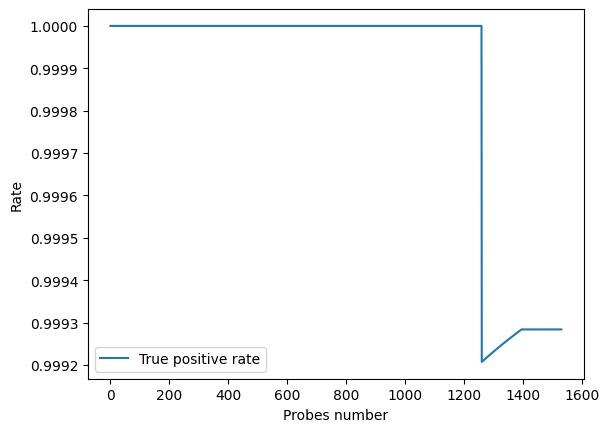

False positive rate vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [174]:
plt.plot(tpr_vec, label='True positive rate')
plt.legend()
plt.xlabel("Probes number")
plt.ylabel("Rate")

plt.show()
print(f'False positive rate vector: {fpr_vec}')

#min_point=np.min(tpr_vec)
#max_point=np.max(tpr_vec)

#area = np.trapz(tpr_vec, dx=1)
#print(f'AUC: {area}')


In [173]:
#roc_auc_score(tpr_vec,1532*[1])

ValueError: continuous format is not supported

In [175]:
# F1 Score
precision = tp_value/(tp_value+fp_value)
recall = tp_value/(tp_value+fn_value)
f1_score = 2/(1/precision + 1/recall)
print(f1_score)

0.9996417054819061


In [176]:
# Mean Absolute Error
result=0
N=len(y_test)

for i in range(0,N):
    result+=(abs(y_test[i]-y_pred[i]))

mae = 1/N * result
print(mae)

0.0006527415143603133


In [177]:
# Mean Squared Error
result=0
N=len(y_test)

for i in range(0,N):
    result+=(y_test[i]-y_pred[i])**2

mae = 1/N * result
print(mae)

0.0006527415143603133


In [ ]:
# sprawdz absolute i squared dla binary
# macierz jakas tam
# auc